In [ ]:
# !pip install pandas
# !pip install statsmodels
# !pip install matplotlib
#pip install skforecast
#!pip install seaborn
#pip install xgboost

## Importación Librerias

In [2]:
import pandas as pd
import requests
from io import BytesIO
from io import StringIO
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import calendar
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from skforecast.model_selection import grid_search_forecaster
from datetime import datetime
from sklearn import metrics  # Para scikit-learn
from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
import itertools

## Importación bases cliente

In [3]:
# URL del repositorio en GitHub
repo_url = 'https://api.github.com/repos/Pacheco-Carvajal/GPA-Data-ElectroDunas/contents/'

# Haz una solicitud GET a la API de GitHub para obtener la lista de archivos en el directorio
response = requests.get(repo_url)
file_data = response.json()

# Filtra los archivos que contienen "datos cliente" en su nombre
desired_files = [(file['download_url'], file['name']) for file in file_data if 'DATOSCLIENTE' in file['name']]

# Crea un DataFrame combinando todos los archivos encontrados
dfs = []
for file_url, file_name in desired_files:
    response = requests.get(file_url)
    content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(content))

    # Agrega una columna "fuente" con el nombre del archivo
    df['fuente'] = file_name

    dfs.append(df)

# Concatena los DataFrames en uno solo
result_df = pd.concat(dfs, ignore_index=True)

## Importación sector clientes

In [4]:
# URL cruda del archivo en GitHub
url = "https://github.com/Pacheco-Carvajal/GPA-Data-ElectroDunas/raw/main/sector_economico_clientes.xlsx"

# Cargar el archivo Excel en un DataFrame
sectores = pd.read_excel(url)

# Mostrar las primeras filas del DataFrame
sectores.head()

,Cliente:,Sector Económico:
0,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,Cliente 2,Elaboración de cacao y chocolate y de producto...
2,Cliente 3,Elaboración de cacao y chocolate y de producto...
3,Cliente 4,Elaboración de cacao y chocolate y de producto...
4,Cliente 5,Elaboración de cacao y chocolate y de producto...


In [5]:
# Extraer los números de la columna 'fuente'
result_df['fuente'] = result_df['fuente'].str.extract('(\d+)')

# Concatenar 'Cliente' con los números extraídos
result_df['fuente'] = 'Cliente ' + result_df['fuente']

result_df.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,fuente
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1


In [6]:
result_df = result_df.rename(columns={'fuente': 'Cliente'})
sectores = sectores.rename(columns={'Cliente:': 'Cliente'})
sectores['Cliente'] = sectores['Cliente'].str.strip()

In [7]:
result_df = pd.merge(result_df, sectores[['Cliente', 'Sector Económico:']], on='Cliente', how='left')
result_df.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico:
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...


In [8]:
result_df = result_df.rename(columns={'Sector Económico:': 'Sector Económico'})
result_df['Fecha'] = pd.to_datetime(result_df['Fecha'])
#Impuación a cero
result_df['Active_energy'] = result_df['Active_energy'].apply(lambda x: 0 if x < 0 else x)

# Ejecucion con Energia Activa LSTM

Parámetros del modelo

In [121]:
num_cliente = 16
imputando = False
frecuencia = '24H'
num_rezagos = 15
num_neuronas = 100
epochs = 25
funcion_activacion = 'tanh'

In [122]:
if imputando:
    # Calcula la media por cliente
    media_por_cliente = result_df.groupby('Cliente')['Active_energy'].mean()

    # Imputa los valores cero con la media correspondiente por cliente
    result_df['Active_energy'] = result_df.apply(lambda row: media_por_cliente[row['Cliente']] if row['Active_energy'] == 0 else row['Active_energy'], axis=1)

In [123]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))) * 100

In [124]:
# Definir función para evaluación métrica
def evaluacion_metrica(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calcular métricas
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    # Devolver métricas como un diccionario
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

In [125]:
# Iterar sobre cada cliente ajustando parámetros
resultados_totales = []  # Lista para almacenar los resultados de todos los clientes

for numero_cliente in [num_cliente]:
    cliente = 'Cliente ' + str(numero_cliente)
    cliente_df = result_df[result_df['Cliente'] == cliente].copy()
    
    # Ordenar los datos por fecha de manera ascendente
    cliente_df = cliente_df.sort_values(by='Fecha')
    
    # Obtener la columna de 'Active_energy' y establecer 'Fecha' como índice
    data_completa = cliente_df[['Fecha', 'Active_energy']]
    print(len(data_completa))
    data_completa.set_index('Fecha', inplace=True)
    
    # Iterar sobre diferentes frecuencias y rezagos
    frecuencias = [frecuencia]
    n_back = [num_rezagos]
    
    # Seleccionar solo el 90% de los datos
    data_completa = data_completa.iloc[:int(0.9 * len(data_completa))]

    # Crear una lista para almacenar los resultados
    resultados_cliente = []

    for frecuencia in frecuencias:
        # Resample los datos a la frecuencia especificada y sumar la energía activa
        data_completa_diaria = data_completa.resample(frecuencia).sum()

        # Reiniciar el índice para que 'Fecha' sea una columna nuevamente
        data_completa_diaria.reset_index(inplace=True)

        # Agregar columnas de mes y hora
        # data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
        # data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour

        # Establecer el índice en 'Fecha' y la frecuencia
        data_completa_diaria.set_index('Fecha', inplace=True)
        data_completa_diaria.index.freq = frecuencia

        # Eliminar filas con valores NaN
        data_completa_diaria.dropna(inplace=True)

        #Bases LSTM
        dataindex= pd.to_datetime(data_completa_diaria.index)
        dt2= data_completa_diaria.to_numpy()
        close_data = dt2.reshape((-1,1))
        
        split_percent = 0.80
        split = int(split_percent*len(close_data))

        #Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
        close_train = close_data[:split]
        close_test = close_data[split:]
        
        date_train = dataindex[:split]
        date_test = dataindex[split:]
                
        for rezago in n_back:
            train_generator = TimeseriesGenerator(close_train, close_train, length=rezago, batch_size=10) 
            test_generator = TimeseriesGenerator(close_test, close_test, length=rezago, batch_size=1)

            # Definir diferentes combinaciones de hiperparámetros
            neuronas = [num_neuronas]
            f_activacion = [funcion_activacion] # ,'relu'
            num_epochs = [epochs]
 
            # Obtener todas las combinaciones de hiperparámetros
            param_combinations = itertools.product(neuronas, f_activacion, num_epochs)

            # Iterar sobre cada combinación de hiperparámetros
            for params in param_combinations:
                model = Sequential()
                model.add(
                    LSTM(params[0],  ## de nodos, dependerá de su poder de cómputo.
                         activation=params[1], #relu #función de activación.
                         input_shape=(rezago,1))   ##la longitud de la secuencia
                )
                model.add(Dense(1))  #capa de salida de predicción
                model.compile(optimizer='adam', loss=mean_absolute_percentage_error)
                
                # model.fit_generator(train_generator, epochs=num_epochs, verbose=0)
                model.fit(train_generator, epochs=params[2], verbose=0)
                
                history = model.fit(train_generator, epochs=params[2], verbose=0)

                #Predicción en el set de prueba:
                prediction = model.predict(test_generator)
                
                #El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
                close_train = close_train.reshape((-1))
                close_test = close_test.reshape((-1))
                prediction = prediction.reshape((-1))
                selected_data = close_test[rezago:]

                # Evaluar métricas de rendimiento
                metricas = evaluacion_metrica(selected_data, prediction)
                
                # Almacenar resultados en la lista
                resultados_cliente.append({
                    'Cliente': cliente,
                    'Frecuencia': frecuencia,
                    'Rezago': rezago,
                    'Modelo': 'LSTM',
                    'Hiperparametros': params,
                    **metricas,  # Desempaquetar métricas como un diccionario
                    'Len_train': len(close_train),
                    'Len_test': len(prediction),
                    'Len_total': len(close_data)
                })

    # Agregar resultados de este cliente a la lista de resultados totales
    resultados_totales.extend(resultados_cliente)

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_totales)

# Mostrar resultados
resultados_df

19500
132/132 [==============================] - 1s 2ms/step


,Cliente,Frecuencia,Rezago,Modelo,Hiperparametros,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
0,Cliente 16,24H,15,LSTM,"(100, tanh, 25)",0.569434,0.343437,0.754609,4.035411,-0.017275,585,132,732


## Pronóstico con el 5% (del 90 al 95% de las serie)

In [126]:
for numero_cliente in [num_cliente]:
    cliente = 'Cliente ' + str(numero_cliente)
    cliente_df = result_df[result_df['Cliente'] == cliente].copy()
    
    # Ordenar los datos por fecha de manera ascendente
    cliente_df = cliente_df.sort_values(by='Fecha')
    
    # Obtener la columna de 'Active_energy' y establecer 'Fecha' como índice
    data_completa = cliente_df[['Fecha', 'Active_energy']]
    print(len(data_completa))
    data_completa.set_index('Fecha', inplace=True)
    
    # Iterar sobre diferentes frecuencias y rezagos
    frecuencias = [frecuencia]
    n_back = [num_rezagos]
    
    # Seleccionar solo el 90% de los datos
    data_completa = data_completa.iloc[:int(0.95 * len(data_completa))]

    # Crear una lista para almacenar los resultados
    resultados_cliente = []

    for frecuencia in frecuencias:
        # Resample los datos a la frecuencia especificada y sumar la energía activa
        data_completa_diaria = data_completa.resample(frecuencia).sum()

        # Reiniciar el índice para que 'Fecha' sea una columna nuevamente
        data_completa_diaria.reset_index(inplace=True)

        # Agregar columnas de mes y hora
        # data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
        # data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour

        # Establecer el índice en 'Fecha' y la frecuencia
        data_completa_diaria.set_index('Fecha', inplace=True)
        data_completa_diaria.index.freq = frecuencia

        # Eliminar filas con valores NaN
        data_completa_diaria.dropna(inplace=True)

        #Bases LSTM
        dataindex= pd.to_datetime(data_completa_diaria.index)
        dt2= data_completa_diaria.to_numpy()
        close_data = dt2.reshape((-1,1))
        
        split_percent = 0.95
        split = int(split_percent*len(close_data))

        #Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
        close_train = close_data[:split]
        close_test = close_data[split:]
        
        date_train = dataindex[:split]
        date_test = dataindex[split:]
                
        for rezago in n_back:
            test_generator = TimeseriesGenerator(close_test, close_test, length=rezago, batch_size=1)

            #Predicción en el set de prueba:
            prediction = model.predict(test_generator)

            #El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
            close_train = close_train.reshape((-1))
            close_test = close_test.reshape((-1))
            prediction = prediction.reshape((-1))
            selected_data = close_test[rezago:]



19500
24/24 [==============================] - 0s 3ms/step


In [127]:
len(close_test)

39

## Generación Amonalias

In [128]:
# Después de obtener la predicción del modelo
# prediction = model.predict(test_generator)
# prediction = prediction.reshape((-1))  # Aplanar la predicción

# Definir un porcentaje para los umbrales
porcentaje_umbral = 0.15  # 10%

# Calcular umbrales
umbral_superior = prediction * (1 + porcentaje_umbral)
umbral_inferior = prediction * (1 - porcentaje_umbral)

24


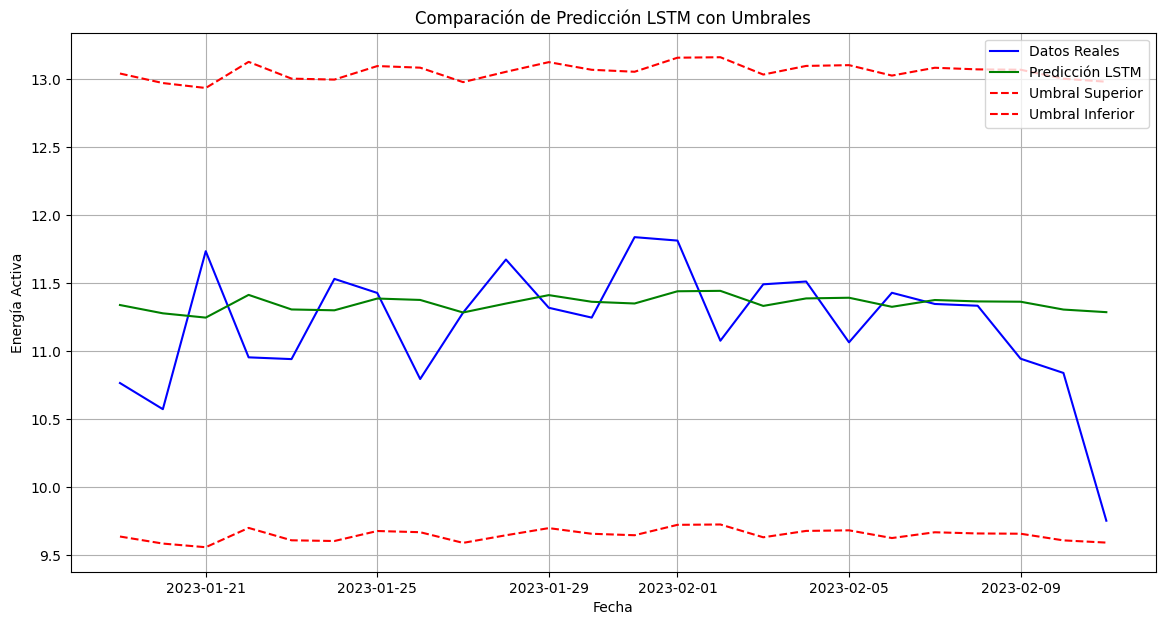

In [129]:
# Asegurarse de tener datos de fechas para el eje X
date_test_trimmed = date_test[rezago:]  # Recortar las fechas para coincidir con el tamaño del array ajustado de prueba

print(len(date_test_trimmed))

plt.figure(figsize=(14, 7))
plt.plot(date_test_trimmed, selected_data, label='Datos Reales', color='blue')
plt.plot(date_test_trimmed, prediction, label='Predicción LSTM', color='green')
plt.plot(date_test_trimmed, umbral_superior, label='Umbral Superior', linestyle='--', color='red')
plt.plot(date_test_trimmed, umbral_inferior, label='Umbral Inferior', linestyle='--', color='red')
plt.title('Comparación de Predicción LSTM con Umbrales')
plt.xlabel('Fecha')
plt.ylabel('Energía Activa')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
# Convertir las predicciones y los intervalos de confianza en DataFrames con el mismo índice que test_feature
real_df = pd.DataFrame(selected_data, index=date_test_trimmed, columns=['Active_energy'])
fcst_df = pd.DataFrame(prediction, index=date_test_trimmed, columns=['Predicted'])
lower_bound_df = pd.DataFrame(umbral_inferior, index=date_test_trimmed, columns=['Lower_Bound'])
upper_bound_df = pd.DataFrame(umbral_superior, index=date_test_trimmed, columns=['Upper_Bound'])

# Combinar test_feature, fcst_df, lower_bound_df y upper_bound_df en un solo DataFrame
combined_df = pd.concat([real_df, fcst_df, lower_bound_df, upper_bound_df], axis=1)
combined_df['anomalias'] = ((combined_df['Active_energy'] > combined_df['Upper_Bound']) |
                            (combined_df['Active_energy'] < combined_df['Lower_Bound']))

# Imprimir el DataFrame resultante
combined_df.head(5)

,Active_energy,Predicted,Lower_Bound,Upper_Bound,anomalias
Fecha,,,,,
2023-01-19,10.766352,11.339499,9.638574,13.040423,False
2023-01-20,10.574166,11.278557,9.586774,12.970340,False
2023-01-21,11.734853,11.247004,9.559954,12.934053,False
2023-01-22,10.955026,11.413982,9.701885,13.126080,False
2023-01-23,10.942145,11.306858,9.610829,13.002887,False


In [131]:
resumen_anomalias = combined_df['anomalias'].value_counts()
resumen_anomalias

False    24
Name: anomalias, dtype: int64

### Iterar umbrales

24


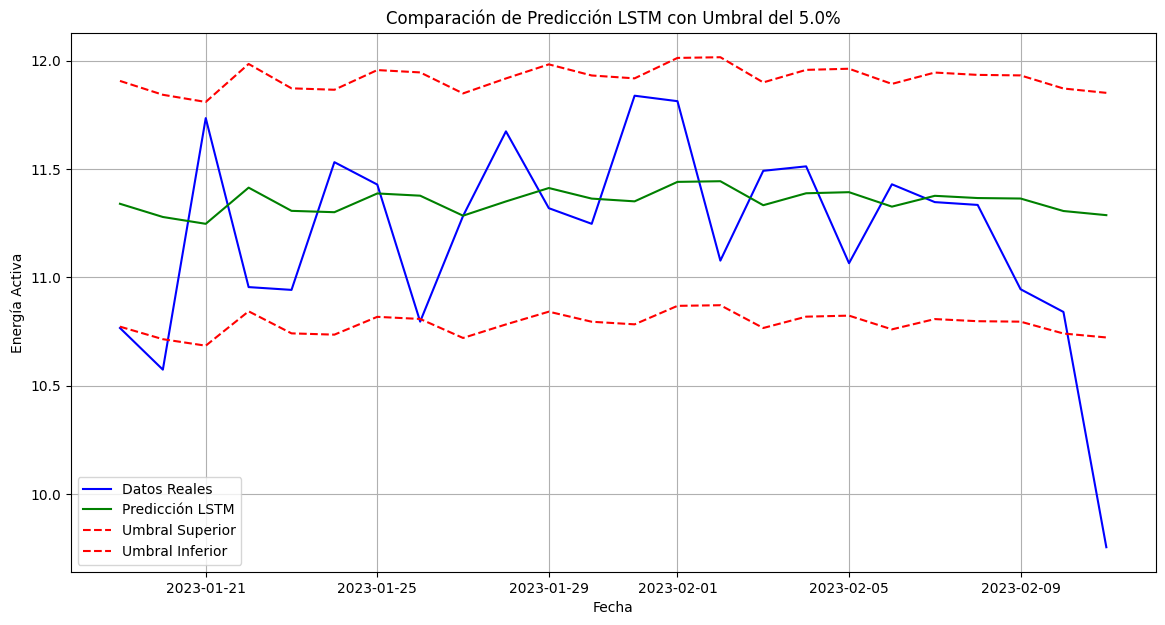

24


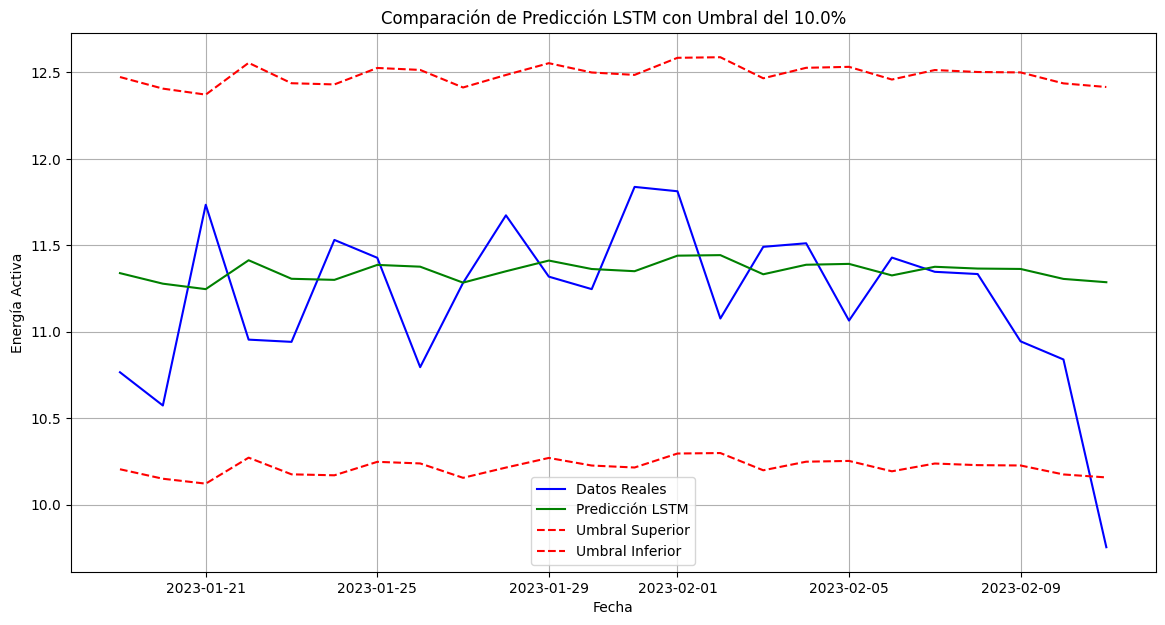

24


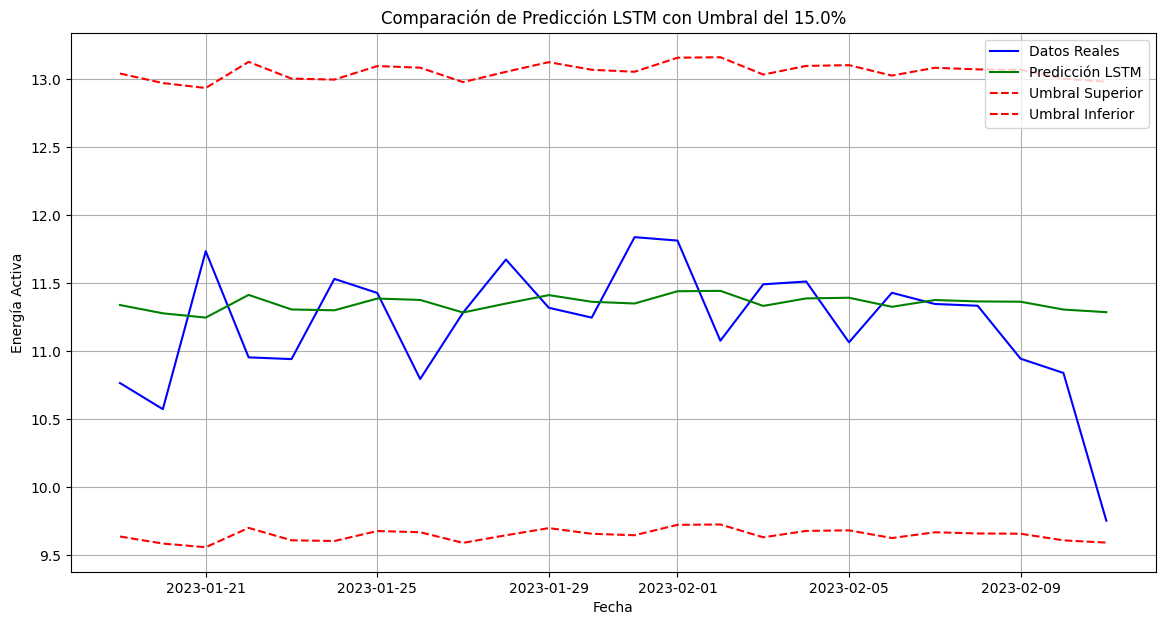

24


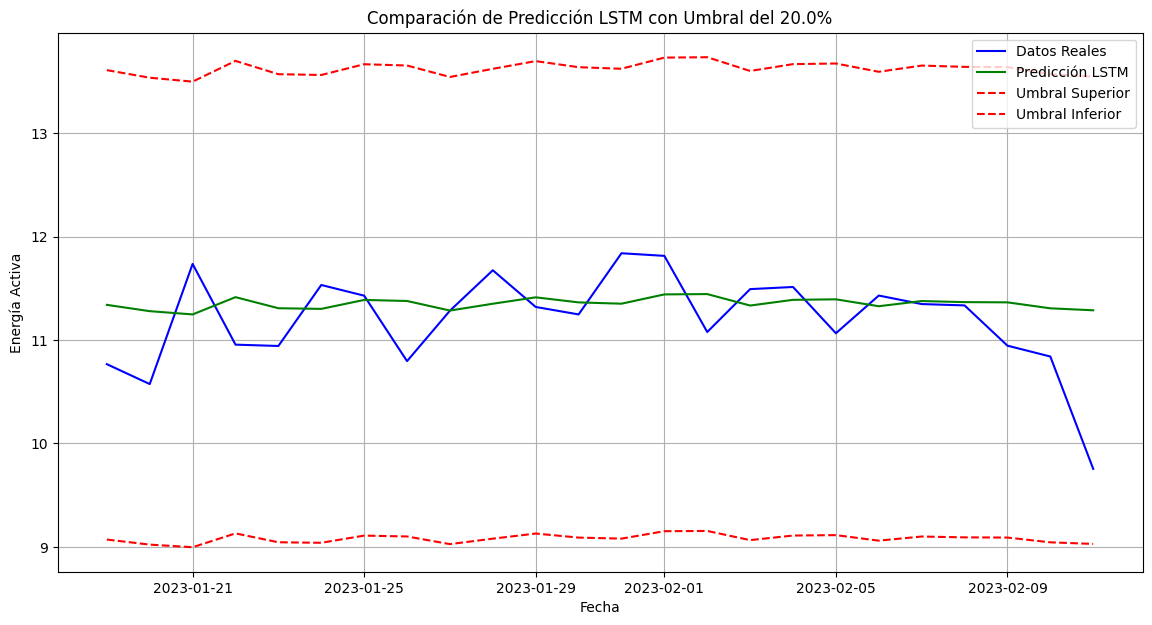

In [134]:
# Definir un porcentaje para los umbrales
umbrales = [0.05, 0.10, 0.15, 0.2]

umbral_results = []

for porcentaje_umbral in umbrales:

    # Calcular umbrales
    umbral_superior = prediction * (1 + porcentaje_umbral)
    umbral_inferior = prediction * (1 - porcentaje_umbral)
    
    # Asegurarse de tener datos de fechas para el eje X
    date_test_trimmed = date_test[rezago:]  # Recortar las fechas para coincidir con el tamaño del array ajustado de prueba

    print(len(date_test_trimmed))

    plt.figure(figsize=(14, 7))
    plt.plot(date_test_trimmed, selected_data, label='Datos Reales', color='blue')
    plt.plot(date_test_trimmed, prediction, label='Predicción LSTM', color='green')
    plt.plot(date_test_trimmed, umbral_superior, label='Umbral Superior', linestyle='--', color='red')
    plt.plot(date_test_trimmed, umbral_inferior, label='Umbral Inferior', linestyle='--', color='red')
    plt.title('Comparación de Predicción LSTM con Umbral del '+ str(porcentaje_umbral*100)+'%')
    plt.xlabel('Fecha')
    plt.ylabel('Energía Activa')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Convertir las predicciones y los intervalos de confianza en DataFrames con el mismo índice que test_feature
    real_df = pd.DataFrame(selected_data, index=date_test_trimmed, columns=['Active_energy'])
    fcst_df = pd.DataFrame(prediction, index=date_test_trimmed, columns=['Predicted'])
    lower_bound_df = pd.DataFrame(umbral_inferior, index=date_test_trimmed, columns=['Lower_Bound'])
    upper_bound_df = pd.DataFrame(umbral_superior, index=date_test_trimmed, columns=['Upper_Bound'])

    # Combinar test_feature, fcst_df, lower_bound_df y upper_bound_df en un solo DataFrame
    combined_df = pd.concat([real_df, fcst_df, lower_bound_df, upper_bound_df], axis=1)
    combined_df['anomalias'] = ((combined_df['Active_energy'] > combined_df['Upper_Bound']) |
                                (combined_df['Active_energy'] < combined_df['Lower_Bound']))
    
    resumen_anomalias = combined_df['anomalias'].value_counts()
    
    umbral_result = {
        'cliente': cliente,
        'umbral': porcentaje_umbral,
        'anomalia': resumen_anomalias.iloc[1] if len(resumen_anomalias)>1 else 0,
        'no_anomalia': resumen_anomalias.iloc[0]
    }
    
    umbral_results.append(umbral_result)

In [135]:
umbral_df = pd.DataFrame(umbral_results)
umbral_df

,cliente,umbral,anomalia,no_anomalia
0,Cliente 16,0.05,4,20
1,Cliente 16,0.10,1,23
2,Cliente 16,0.15,0,24
3,Cliente 16,0.20,0,24


In [ ]:
#consolidado_lstm = pd.DataFrame(columns=['cliente', 'umbral', 'anomalia', 'no_anomalia'])

In [136]:
consolidado_lstm = pd.concat([consolidado_lstm, umbral_df], axis=0)

In [137]:
consolidado_lstm

,cliente,umbral,anomalia,no_anomalia
0,Cliente 13,0.05,5,8
1,Cliente 13,0.10,5,8
2,Cliente 13,0.15,1,12
3,Cliente 13,0.20,1,12
0,Cliente 14,0.05,2,11
1,Cliente 14,0.10,6,7
2,Cliente 14,0.15,4,9
3,Cliente 14,0.20,2,11
0,Cliente 16,0.05,4,20
1,Cliente 16,0.10,1,23


In [139]:
consolidado_lstm.groupby('umbral')[['anomalia', 'no_anomalia']].sum()

,anomalia,no_anomalia
umbral,,
0.05,11,39
0.10,12,38
0.15,5,45
0.20,3,47
